Pupil Core device timing
========================

`PupilCore().light_stamper(...)` marks the onset of a light stimulus by sending an annotation containing the timestamp of the first frame where the light becomes visible to the world camera. This timestamp is ultimately what gets used to extract pupil data and as a reference for calculating time-critical measures, such as constriction latency and time-to-peak constriction. The validity of any time-related measures therefore depends on Pupil Capture's ability to synchronise the clocks of the cameras on a Pupil Core headset. How well does it handle this task? When we discovered that the near-infrared from STLABs amber channel gets detected by both eye and world cameras, we were able to [design a protocol](05e_pupil_core_camera_sync.ipynb) to test this ourselves using the `.light_stamper(...)` method. The protocol basically involved putting the Pupil Core headset inside the integrating sphere and repeatedly flashing a bright orange light in a dark room. Prior to each flash, we instantiate a `.light_stamper(...)` for each of the cameras, which gives us the pupil timestamp from the frame where the light was detected for each camera. This allows us to get some insight into how well the data streams are synchronised. 

We run the testing protocol on Mac and Windows with 60 and 120 FPS, for *n* = 100 near-IR light flashes. 


In [1]:
import os
import os.path as op
import glob

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('notebook')

Calculate differences from annotation timestamps
------------------------------------------------

In [2]:
datadir = '/Users/jtm/OneDrive - Nexus365/data/pupil_core_camera_sync_tests'
recordings = glob.glob(datadir + '/**/**/**/annotations.csv')

data = pd.DataFrame()
for rec in recordings:
    # Load annotations and get camera timestamps for detected light flash
    df = pd.read_csv(rec)
    eye_0 = df.loc[df.label=='light_on_eye_0', 'timestamp'].to_numpy()
    eye_1 = df.loc[df.label=='light_on_eye_1', 'timestamp'].to_numpy() 
    world = df.loc[df.label=='light_on_world', 'timestamp'].to_numpy()
    
    # Calculate timestamp differences and make DataFrame
    diffs = (pd.DataFrame(data=[(eye_0-world)*1000,
                                (eye_1-world)*1000,
                                (eye_0-eye_1)*1000],
                          index=['eye0 - world',
                                 'eye1 - world',
                                 'eye0 - eye1'])
               .T.melt(var_name='Comparison', 
                       value_name='Timestamp difference (ms)'))
    
    # Add categories for operating system and frames per second
    diffs['OS'] = 'Mac' if 'mac' in rec else 'Windows'
    diffs['FPS'] = '120' if '120_fps' in rec else '60'
    diffs.to_csv(op.join(op.dirname(rec), 'annotation_timestamp_diffs.csv'))
    
    # Append to master frame
    data = data.append(diffs)
data

Comparison  Timestamp difference (ms)       OS  FPS
0    eye0 - world                     58.807  Windows  120
1    eye0 - world                     55.010  Windows  120
2    eye0 - world                     58.925  Windows  120
3    eye0 - world                     57.622  Windows  120
4    eye0 - world                     58.371  Windows  120
..            ...                        ...      ...  ...
295   eye0 - eye1                     -3.959      Mac   60
296   eye0 - eye1                     -3.968      Mac   60
297   eye0 - eye1                     12.266      Mac   60
298   eye0 - eye1                     -3.984      Mac   60
299   eye0 - eye1                     -3.991      Mac   60

[1200 rows x 4 columns]

Plot the timestamp differences
------------------------------

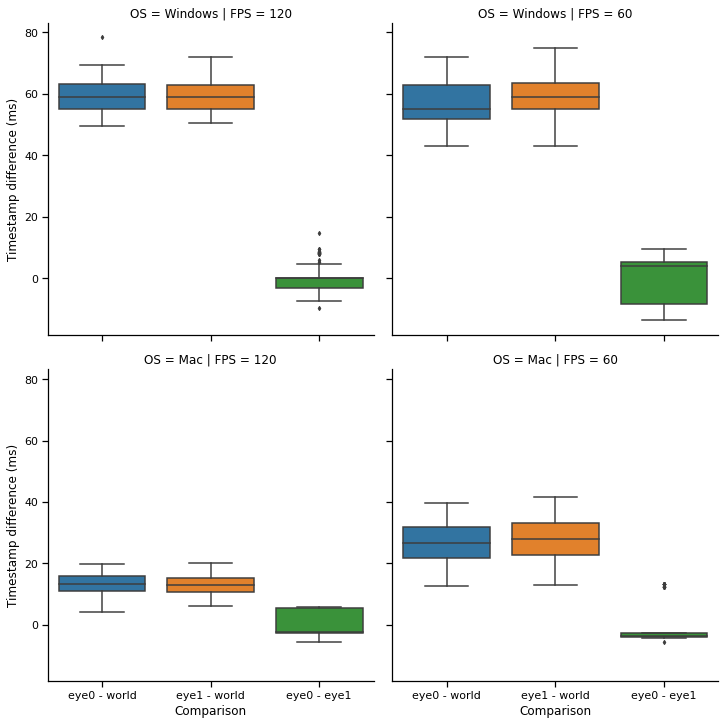

In [3]:
g = sns.catplot(data=data, 
                x='Comparison', 
                y='Timestamp difference (ms)', 
                row='OS', 
                col='FPS',
                kind='box', 
                order=['eye0 - world', 'eye1 - world', 'eye0 - eye1'],
                flierprops={'markersize':3})

Interpretation
--------------

More information here...